In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from torchvision.transforms import v2


In [5]:
from pymono.cnns import cnn_evaluation, x_single_run, x_train_cnn
from pymono.cnns import Conv2dPars,  MaxPool2dPars,  LinealLayerPars
from pymono.cnns import build_conv_layer, build_conv_layers, build_linear_layers
from pymono.cnns import CNN, ResNet10, ResNet8, ResBlock

In [6]:
from pymono.plt_funcs import  plot_loss, plot_accuracy, cifar_plot_image_and_label 
from pymono.plt_funcs import  plot_energies2, histoplot
from pymono.cnn_plots import plot_images2, plot_images_and_labels

In [7]:
from pymono.cnn_aux import get_file_names_format1, get_image_file_data, get_img_file_metadata
from pymono.cnn_aux import get_energy2, get_means_stds2

In [8]:
from pymono.xdataset import XDataset 
from pymono.mono_dl import mono_data_loader

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Local functions

In [10]:
def print_features(train_loader):
    train_features, train_labels = next(iter(train_loader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

## Voxelization at 12 mm
- df1c is the directory containing images and labels for events classified as single cluster (1c)
- df2c is the directory containing images and labels for events classified as double cluster (2c)
- dfnc is the directory containing images and labels for events classified as multiple cluster (nc)
- Files are in format1:
    - images files are of the form: images_n.npy, where n is a number.
    - labels are stored in a single file (labels.csv)

In [11]:
data_dir = Path(os.environ['MONOLITH_DATA'])
dir_root = os.path.join(data_dir,"LYSO_6x6_nowrap_15k_2MHzDC_PTFE_LUT_gamma_vox_12mm")
d1c = os.path.join(dir_root,"df1c")
d2c = os.path.join(dir_root,"df2c")
dnc = os.path.join(dir_root,"dfnc")

In [15]:
img_names, csv_name = get_file_names_format1(d1c)

In [16]:
img_names[0]

'/home/investigator/Data/monolithic_csi/LYSO_6x6_nowrap_15k_2MHzDC_PTFE_LUT_gamma_vox_12mm/df1c/images_1.npy'

In [17]:
csv_name

['/home/investigator/Data/monolithic_csi/LYSO_6x6_nowrap_15k_2MHzDC_PTFE_LUT_gamma_vox_12mm/df1c/df1c_12mm.csv']

### Label data
- When sorted by value, label data corresponds to the image stored in the directory.
- event_id = 10000 x image_number, so that event 1004 corresponds to the fourth image in file images_1.npy

In [18]:
df1c = pd.read_csv(csv_name[0]).sort_values(by="event_id")
df1c.head(10)

,event_id,e,x,y,z,t
374814,10001,0.509325,-17.217510,19.075306,3.070376,0.056111
374815,10002,0.510251,-3.097184,-17.359003,15.376202,0.098884
374816,10004,0.510363,-16.972713,-6.130193,1.859217,0.052260
374817,10005,0.508885,8.986159,-12.586908,2.650704,0.061724
374818,10006,0.510986,7.318175,16.940788,15.689467,0.101741
374819,10008,0.509998,6.459206,-18.942260,11.047173,0.094012
374820,10009,0.509237,-12.135721,15.002206,12.276846,0.086367
374821,10012,0.508924,2.430651,20.647509,10.874989,0.079377
374822,10014,0.510330,2.515096,-22.471401,14.173119,0.093255
374823,10018,0.508881,-22.551577,8.961385,5.454608,0.062542


#### Example
- Images and labels in first file of directory

In [19]:
imgs, imgf_path, imgf_name, imfn = get_image_file_data(img_names,img_file_index=0)
print(f"image file path = {imgf_path}")
print(f"image file name = {imgf_name}")
print(f"image file number = {imfn}")
print(f"number of images in file = {len(imgs)}")

image file path = /home/investigator/Data/monolithic_csi/LYSO_6x6_nowrap_15k_2MHzDC_PTFE_LUT_gamma_vox_12mm/df1c/images_1.npy
image file name = images_1.npy
image file number = 1
number of images in file = 4585


In [20]:
df1cs = get_img_file_metadata(df1c, imfn)  # This are the events corresponding to the images
print(f"number of labels in file = {len(df1cs)}")

number of labels in file = 4585


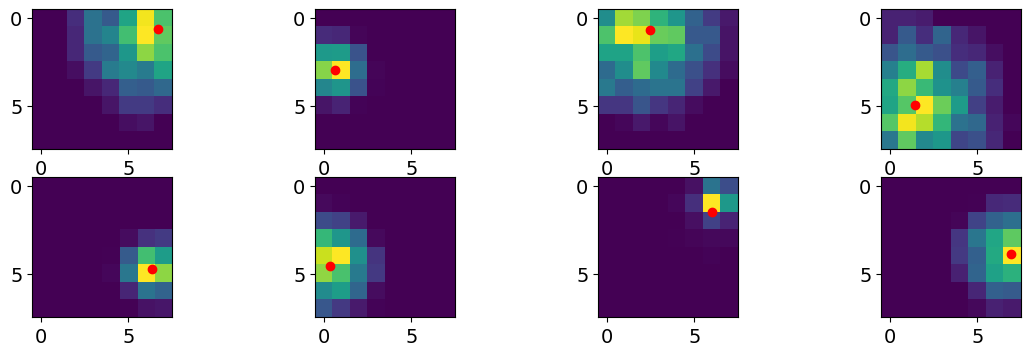

In [21]:
plot_images2(imgs, df1cs, (0,8), pixel_size = 6, grid_size=8)

In [25]:
energy = get_energy2(imgs)

In [27]:
energy

array([ 693., 1434., 1047., ..., 1323.,  972., 1225.], dtype=float32)

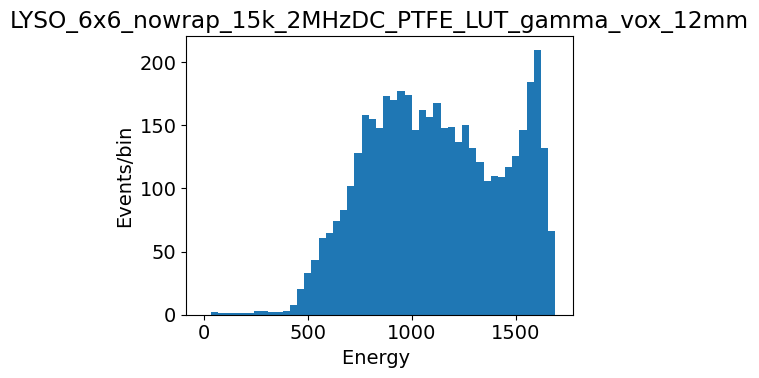

In [28]:
plot_energies2({"LYSO_6x6_nowrap_15k_2MHzDC_PTFE_LUT_gamma_vox_12mm":energy}, xmin=0.0, xmax=max(energy),num_bins = 50)

## Load data
- No normalization. 

In [29]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 100  # Batch size
train_fraction=0.7 
val_fraction=0.2

In [30]:
dataset = XDataset(dir_root, first_file, last_file,norm=False)  

Running XDataset with norm = False
directory for 1c = /home/investigator/Data/monolithic_csi/LYSO_6x6_nowrap_15k_2MHzDC_PTFE_LUT_gamma_vox_12mm/df1c, 2c = /home/investigator/Data/monolithic_csi/LYSO_6x6_nowrap_15k_2MHzDC_PTFE_LUT_gamma_vox_12mm/df2c, >2c = /home/investigator/Data/monolithic_csi/LYSO_6x6_nowrap_15k_2MHzDC_PTFE_LUT_gamma_vox_12mm/dfnc
 Image type = 0
 Image type = 1
 Image type = 1
Before shufle: length si: 642335, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 642335, si->[547753, 454898, 502579, 225504, 516738, 305692, 357838, 306689, 551941, 461455]


In [31]:
dataset[3]

(tensor([[[ 6., 13., 28., 20., 54., 32., 33., 15.],
          [14., 13., 27., 41., 47., 45., 24., 16.],
          [ 8., 18., 29., 41., 54., 40., 38., 18.],
          [ 4.,  8., 28., 37., 48., 32., 33., 24.],
          [ 8., 10., 17., 27., 28., 34., 18., 16.],
          [ 1.,  8., 11., 15., 16., 24., 11.,  5.],
          [ 0.,  1.,  8.,  6.,  8., 11.,  6.,  2.],
          [ 0.,  0.,  0.,  1.,  1.,  2.,  0.,  0.]]]),
 tensor(0))

In [32]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 642335 events
 train size = 449634
 val size = 128467
 test size = 64234
 train indices = range(0, 449634)
 val indices = range(449634, 578101)
 test indices = range(578101, 642335)
449634 training events (69.99992215899803%)
128467 validation events (20.0%)
64234 test events (10.00007784100197%)


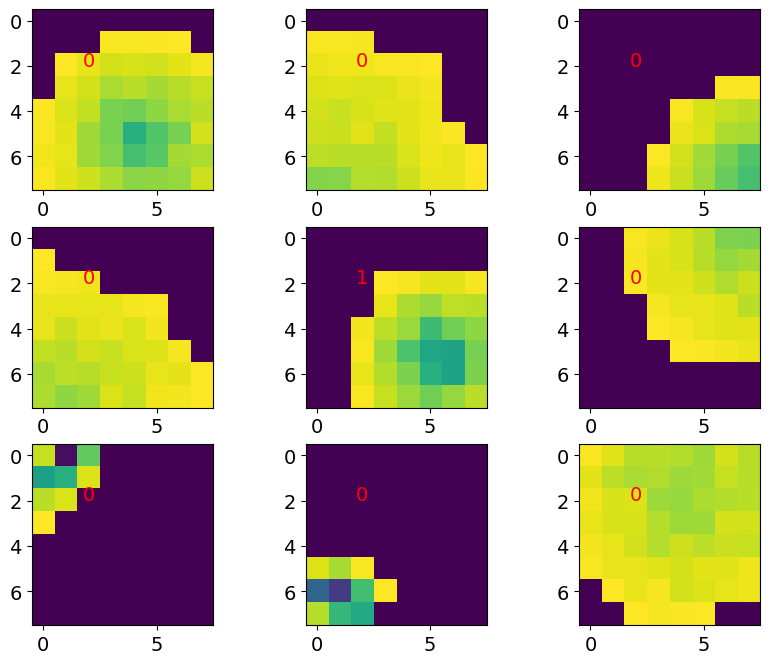

In [33]:
plot_images_and_labels(train_loader, start=500, figsize=(10, 8))

## Define model

In [34]:
CL = []
c1 = Conv2dPars(in_channels=1, out_channels=64, kernel_size=3, padding=1)
c2 = Conv2dPars(in_channels=64, out_channels=128, kernel_size=3, padding=1)
c3 = Conv2dPars(in_channels=128, out_channels=256, kernel_size=2, padding=1)
c4 = Conv2dPars(in_channels=256, out_channels=512, kernel_size=2, padding=1)
p2d = MaxPool2dPars(kernel_size=2, stride=2)
CL.append(build_conv_layer(c1, p2d, relu='standard'))
CL.append(build_conv_layer(c2, p2d, relu='standard'))
CL.append(build_conv_layer(c3, p2d, relu='standard'))
CL.append(build_conv_layer(c4, p2d, relu='standard'))
clyrs = build_conv_layers(CL)

In [35]:
cnn_evaluation(torch.randn(1,1,8,8), CL)

shape of input image = torch.Size([1, 1, 8, 8])
 after cl = 1, shape of out image = torch.Size([1, 64, 4, 4])
 after cl = 2, shape of out image = torch.Size([1, 128, 2, 2])
 after cl = 3, shape of out image = torch.Size([1, 256, 1, 1])
 after cl = 4, shape of out image = torch.Size([1, 512, 1, 1])
shape of flattened image = torch.Size([1, 512])


In [36]:
LLYR=[]
LLYR.append(LinealLayerPars(512, 256))
LLYR.append(LinealLayerPars(256, 128))
LLYR.append(LinealLayerPars(128, 2))
llyrs = build_linear_layers(LLYR, df=0.25)

In [37]:
model = CNN(clyrs,llyrs).to(device)

In [38]:
summary(model,(1,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
         MaxPool2d-4             [-1, 64, 4, 4]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
       BatchNorm2d-6            [-1, 128, 4, 4]             256
              ReLU-7            [-1, 128, 4, 4]               0
         MaxPool2d-8            [-1, 128, 2, 2]               0
            Conv2d-9            [-1, 256, 3, 3]         131,328
      BatchNorm2d-10            [-1, 256, 3, 3]             512
             ReLU-11            [-1, 256, 3, 3]               0
        MaxPool2d-12            [-1, 256, 1, 1]               0
           Conv2d-13            [-1, 512, 2, 2]         524,800
      BatchNorm2d-14            [-1, 51

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)  


In [40]:
x_single_run(train_loader, device, model, optimizer, criterion, xc=True)

** Run for 1 event**
epoch = 0
i = 0
labels shape = torch.Size([100])
imgs shape = torch.Size([100, 1, 8, 8])
labels = tensor([0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1])
outputs = torch.Size([100, 2])
predicted label = tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1], device='cuda:0')
correct = 25
Train Step 1/4497, Loss: 0.7335917949676514
i = 1
labels shape = torch.Size([100])
imgs shape = torch.Size([100, 1, 8, 8

In [41]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->287808 images
size of train loader  ->4497 images
Evaluating with  ->82240 images
size of eval loader  ->1285 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 4497
Validation step: size of sample 1285
--- EPOCH 0 AVG TRAIN LOSS: 0.510702139832376
--- EPOCH 0 AVG VAL LOSS: 0.4516142232640708
Accuracy on the 1285 validation images: 80.7102213019686 %

EPOCH 1
training step: size of sample 4497
Validation step: size of sample 1285
--- EPOCH 1 AVG TRAIN LOSS: 0.43930803599531504
--- EPOCH 1 AVG VAL LOSS: 0.4652643534343994
Accuracy on the 1285 validation images: 79.87031689071901 %

EPOCH 2
training step: size of sample 4497
Validation step: size of sample 1285
--- EPOCH 2 AVG TRAIN LOSS: 0.42244469590629236
--- EPOCH 2 AVG VAL LOSS: 0.4489993111168828
Accuracy on the 1285 validation images: 80.79428958409552 %

EPOCH 3
training step: size of sample 4497
Validation step: size of sample 1285
--- EPOCH 3 AVG TRAIN LOSS: 0.415314032

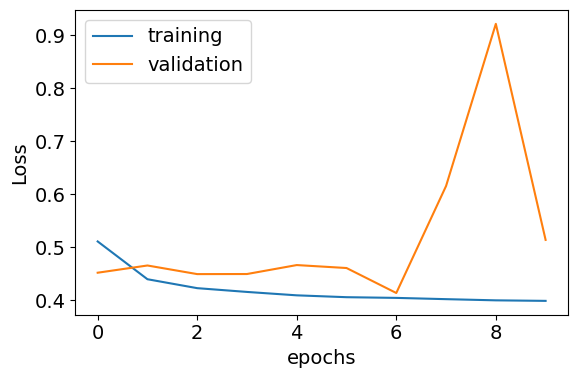

In [42]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

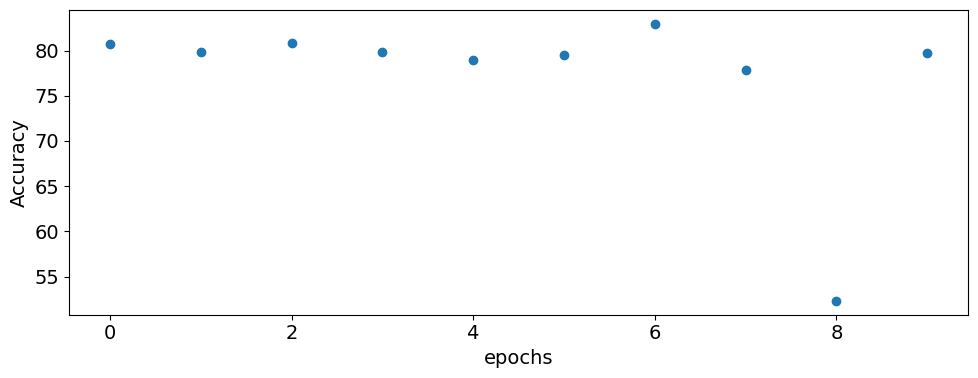

In [43]:
plot_accuracy(acc,figsize=(10, 4))

## Normalization

In [44]:
means, stds = get_means_stds2(dir=d1c)

files in dir: 100
shape -> (4643, 8, 8)
mean img0 =6.71875
std  img0 =4.887703895568848


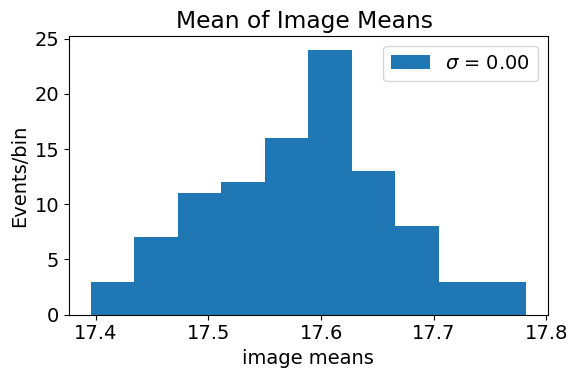

In [45]:
meansx =[np.mean(x) for x in means]
histoplot(meansx, "image means", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [46]:
imean = np.mean(meansx)

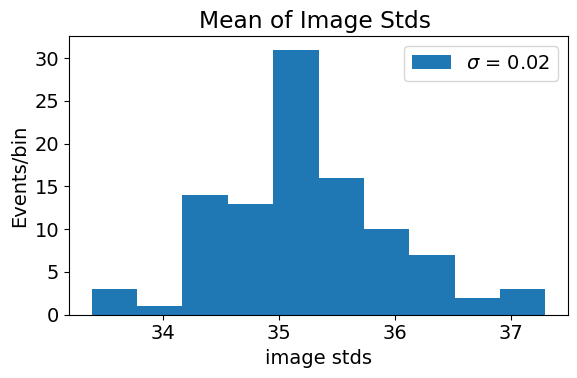

In [47]:
stdsx =[np.std(x) for x in stds]
histoplot(stdsx, "image stds", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [48]:
isigma = np.mean(stdsx)

In [49]:
print(f"Normalization: mean = {imean}, std = {isigma}")

Normalization: mean = 17.58325958251953, std = 35.23804473876953


In [50]:
means2, stds2 = get_means_stds2(dir=d2c)

files in dir: 100
shape -> (1618, 8, 8)
mean img0 =19.90625
std  img0 =17.67742156982422


In [51]:
folder_h5    = "CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5"

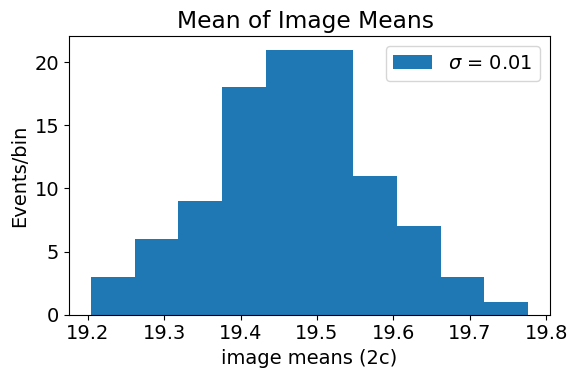

In [52]:
meansx2 =[np.mean(x) for x in means2]
histoplot(meansx2, "image means (2c)", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [53]:
imean2 = np.mean(meansx2)

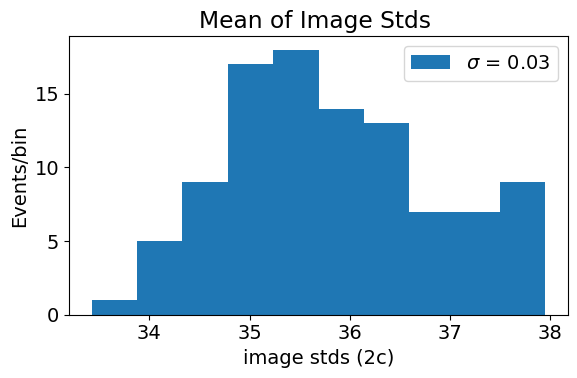

In [54]:
stdsx2 =[np.std(x) for x in stds2]
histoplot(stdsx2, "image stds (2c)", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [55]:
isigma2 = np.mean(stdsx2)

In [56]:
print(f"Normalization 2c: mean = {imean2}, std = {isigma2}")

Normalization 2c: mean = 19.46953582763672, std = 35.832637786865234


In [57]:
means3, stds3 = get_means_stds2(dir=dnc)

files in dir: 100
shape -> (195, 8, 8)
mean img0 =11.359375
std  img0 =23.234111785888672


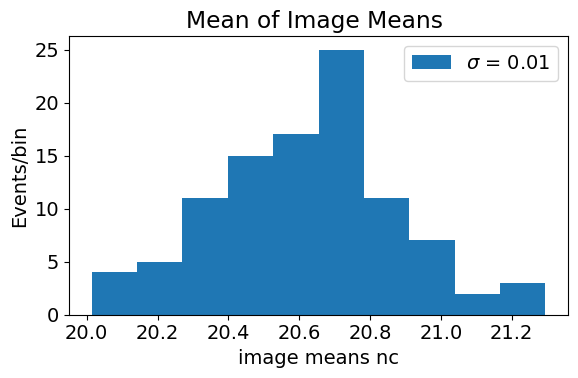

In [58]:
meansx3 =[np.mean(x) for x in means3]
histoplot(meansx3, "image means nc", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [59]:
imean3 = np.mean(meansx3)

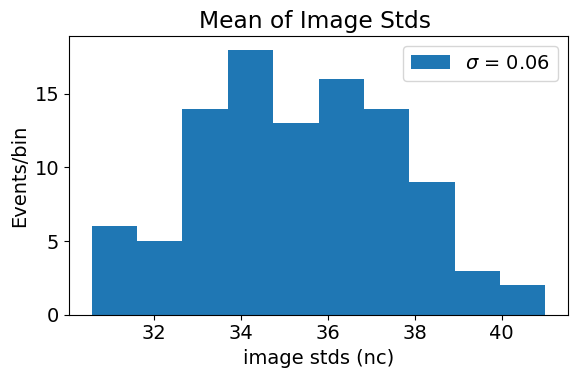

In [60]:
stdsx3 =[np.std(x) for x in stds3]
histoplot(stdsx3, "image stds (nc)", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [61]:
isigma3 = np.mean(stdsx3)

In [62]:
print(f"Normalization nc: mean = {imean3}, std = {isigma3}")

Normalization nc: mean = 20.617076873779297, std = 35.36301040649414


### Run with full stats and normalization

In [63]:
dataset = XDataset(dir_root, first_file, last_file,norm=True, mean=imean, std=isigma)  # No comparison with energy only xyz


Running XDataset with norm = True
directory for 1c = /home/investigator/Data/monolithic_csi/LYSO_6x6_nowrap_15k_2MHzDC_PTFE_LUT_gamma_vox_12mm/df1c, 2c = /home/investigator/Data/monolithic_csi/LYSO_6x6_nowrap_15k_2MHzDC_PTFE_LUT_gamma_vox_12mm/df2c, >2c = /home/investigator/Data/monolithic_csi/LYSO_6x6_nowrap_15k_2MHzDC_PTFE_LUT_gamma_vox_12mm/dfnc
 Image type = 0
 Image type = 1
 Image type = 1
Before shufle: length si: 642335, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 642335, si->[547753, 454898, 502579, 225504, 516738, 305692, 357838, 306689, 551941, 461455]


In [64]:
dataset[3]

(tensor([[[-0.3287, -0.1301,  0.2956,  0.0686,  1.0334,  0.4091,  0.4375,
           -0.0733],
          [-0.1017, -0.1301,  0.2672,  0.6645,  0.8348,  0.7780,  0.1821,
           -0.0449],
          [-0.2720,  0.0118,  0.3240,  0.6645,  1.0334,  0.6362,  0.5794,
            0.0118],
          [-0.3855, -0.2720,  0.2956,  0.5510,  0.8632,  0.4091,  0.4375,
            0.1821],
          [-0.2720, -0.2152, -0.0166,  0.2672,  0.2956,  0.4659,  0.0118,
           -0.0449],
          [-0.4706, -0.2720, -0.1868, -0.0733, -0.0449,  0.1821, -0.1868,
           -0.3571],
          [-0.4990, -0.4706, -0.2720, -0.3287, -0.2720, -0.1868, -0.3287,
           -0.4422],
          [-0.4990, -0.4990, -0.4990, -0.4706, -0.4706, -0.4422, -0.4990,
           -0.4990]]]),
 tensor(0))

In [65]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 642335 events
 train size = 449634
 val size = 128467
 test size = 64234
 train indices = range(0, 449634)
 val indices = range(449634, 578101)
 test indices = range(578101, 642335)
449634 training events (69.99992215899803%)
128467 validation events (20.0%)
64234 test events (10.00007784100197%)


In [66]:
model = CNN(clyrs,llyrs).to(device)

In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)  


In [68]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->287808 images
size of train loader  ->4497 images
Evaluating with  ->82240 images
size of eval loader  ->1285 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 4497
Validation step: size of sample 1285
--- EPOCH 0 AVG TRAIN LOSS: 0.4036275458310693
--- EPOCH 0 AVG VAL LOSS: 0.6174080068267273
Accuracy on the 1285 validation images: 69.18119050028412 %

EPOCH 1
training step: size of sample 4497
Validation step: size of sample 1285
--- EPOCH 1 AVG TRAIN LOSS: 0.3987207700006957
--- EPOCH 1 AVG VAL LOSS: 0.42272804341195624
Accuracy on the 1285 validation images: 81.44504036055952 %

EPOCH 2
training step: size of sample 4497
Validation step: size of sample 1285
--- EPOCH 2 AVG TRAIN LOSS: 0.39694406421205214
--- EPOCH 2 AVG VAL LOSS: 0.49928085516398985
Accuracy on the 1285 validation images: 75.70426646531794 %

EPOCH 3
training step: size of sample 4497
Validation step: size of sample 1285
--- EPOCH 3 AVG TRAIN LOSS: 0.395632

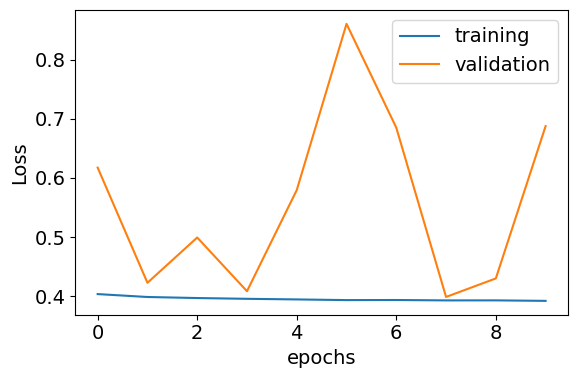

In [69]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

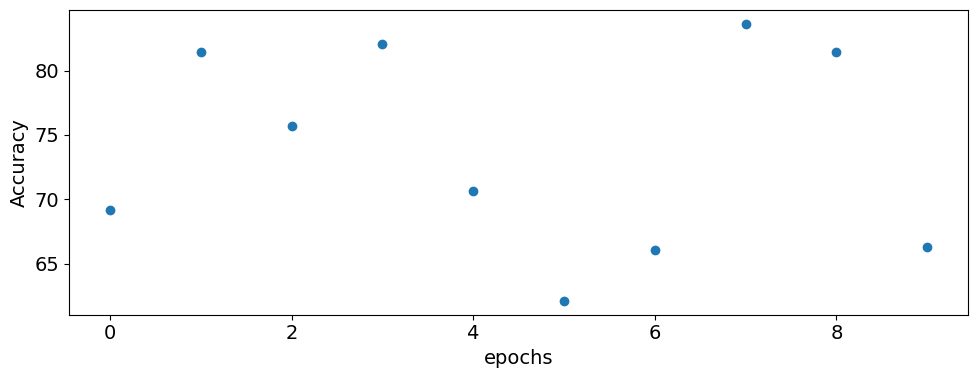

In [70]:
plot_accuracy(acc,figsize=(10, 4))

## Resnet

In [71]:
model = ResNet8(ResBlock, in_channels=1, out_channels=64, num_classes = 2, 
                 dropout_fraction=0.25, debug=True, dropout=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [72]:
model(torch.randn(10,1,8,8).to(device))

  ResNet8: input data shape =>torch.Size([10, 1, 8, 8])
  ResNet8: after conv1 =>torch.Size([10, 64, 8, 8])
  ResNet8: after layer0 =>torch.Size([10, 64, 8, 8])
  ResNet8: after layer1 =>torch.Size([10, 128, 4, 4])
  ResNet8: after layer2 =>torch.Size([10, 256, 2, 2])
  ResNet8: after layer3 =>torch.Size([10, 512, 1, 1])
  ResNet8: after avgpool =>torch.Size([10, 512, 1, 1])
  ResNet8: after flatten =>torch.Size([10, 512])
  ResNet8: after fc =>torch.Size([10, 2])


tensor([[ 0.0486, -0.4028],
        [-1.6123, -0.1296],
        [-1.5663, -1.5858],
        [-0.7764, -0.3387],
        [-0.4315, -0.3916],
        [-0.4920, -0.2201],
        [-0.0332,  0.2082],
        [-0.8435, -0.0179],
        [-1.2635, -0.2060],
        [-0.8585, -0.9090]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [73]:
summary(model,(1,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          36,928
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          36,928
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
         ResBlock-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 4, 4]          73,856
      BatchNorm2d-12            [-1, 128, 4, 4]             256
             ReLU-13            [-1, 128, 4, 4]               0
           Conv2d-14            [-1, 12

In [74]:
optimizer= optim.Adam(model.parameters(), lr=0.001)

In [75]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->287808 images
size of train loader  ->4497 images
Evaluating with  ->82240 images
size of eval loader  ->1285 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 4497
Validation step: size of sample 1285
--- EPOCH 0 AVG TRAIN LOSS: 0.4502000397169407
--- EPOCH 0 AVG VAL LOSS: 0.5440634267339447
Accuracy on the 1285 validation images: 71.34283512497373 %

EPOCH 1
training step: size of sample 4497
Validation step: size of sample 1285
--- EPOCH 1 AVG TRAIN LOSS: 0.37783678332275356
--- EPOCH 1 AVG VAL LOSS: 1.391399524555132
Accuracy on the 1285 validation images: 55.07095207329509 %

EPOCH 2
training step: size of sample 4497
Validation step: size of sample 1285
--- EPOCH 2 AVG TRAIN LOSS: 0.3543154202568974
--- EPOCH 2 AVG VAL LOSS: 0.38713240483159683
Accuracy on the 1285 validation images: 82.95671261880483 %

EPOCH 3
training step: size of sample 4497
Validation step: size of sample 1285
--- EPOCH 3 AVG TRAIN LOSS: 0.33777599

In [75]:
optimizer= optim.Adam(model.parameters(), lr=0.01)

In [76]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=20)

Training with  ->229760 images
size of train loader  ->3590 images
Evaluating with  ->65664 images
size of eval loader  ->1026 images
Classification  ->True
Running for epochs ->20

EPOCH 0
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 0 AVG TRAIN LOSS: 0.5397825823271839
--- EPOCH 0 AVG VAL LOSS: 0.5472000421371609
Accuracy on the 1026 validation images: 71.48039081849562 %

EPOCH 1
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 1 AVG TRAIN LOSS: 0.5363985404662767
--- EPOCH 1 AVG VAL LOSS: 0.5460900588226133
Accuracy on the 1026 validation images: 71.46771456988513 %

EPOCH 2
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 2 AVG TRAIN LOSS: 0.5334186145854195
--- EPOCH 2 AVG VAL LOSS: 0.5466090646113104
Accuracy on the 1026 validation images: 71.60130272831874 %

EPOCH 3
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 3 AVG TRAIN LOSS: 0.530544326

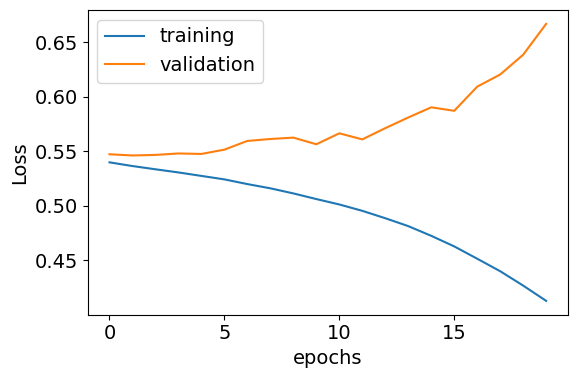

In [77]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))

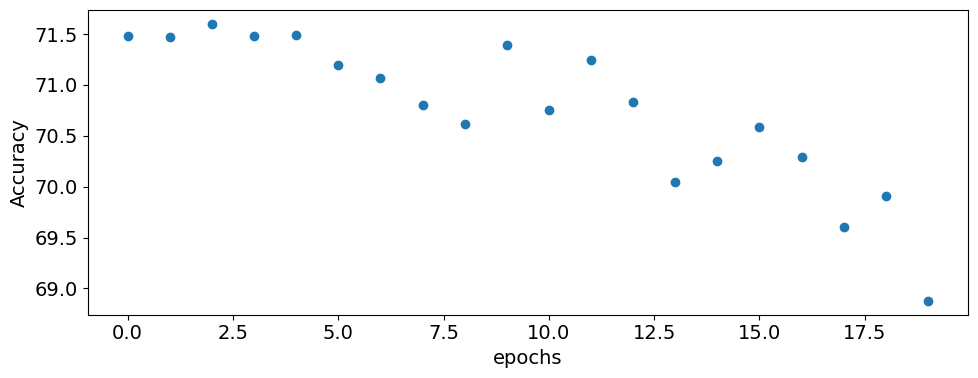

In [78]:
plot_accuracy(acc,figsize=(10, 4))